# Integration - Getting Started
This notebook gives a short introduction into how integration is handled in
`skactiveml`.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import norm

from skactiveml.regressor import NICKernelRegressor
from skactiveml.pool.regression.utils import conditional_expect
from skactiveml.visualization import gaussian_noise_generator_1d

Many query strategies in the field of active learning for regression rely on
numerical integration. Usually it is interesting to know the expected value
of a utility function if a sample x has the target value y. For this expected
value a closed form solution can not always be obtained, hence numerical integration
is necessary. Formally, we try to calculate $\mathbb{E}[f(y)]$, where $y \sim \text{reg.predict_target_distribution($x$)}$
for a utility function $f$. The different ways in which this expected value
can be calculated numerically are handled by the function `conditional_expect`.

To explain this function, consider the following situation: Our utility function at
a given point is given by the function `f` defined below. We are given the samples `X` with labels `y`,
which we use to estimate the target distribution at a point x.
Specifically we use a kernel based regressor `NICKernelRegressor`, which locally
fits a t distribution, to predict the target distributions.
In the plot below, the blue line shows the predicted mean, and the green and orange
line display the deviation from the mean of one standard deviation.


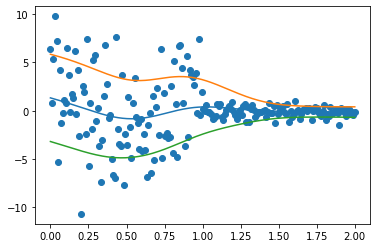

In [7]:
random_state = 0
n_samples = 200
x_low, x_up = 0, 2

def f(X):
    return - 1/10*X**3 + X**2 + 8*X + 16

def noise_gen(X):
    return gaussian_noise_generator_1d(X, (0, 1, 4), (0, 1, 1), random_state=random_state)

X = np.linspace(x_low, x_up, num=n_samples).reshape(-1, 1)
y = noise_gen(X)
reg = NICKernelRegressor(metric_dict={'gamma': 10.0})
reg.fit(X, y)

_, ax = plt.subplots()
mean, std = reg.predict(X, return_std=True)
ax.scatter(X, y)
ax.plot(X, mean)
ax.plot(X, mean + std)
ax.plot(X, mean - std)

We now want to know at each point in the feature space, what the expected utility is.
For this specific function a closed form solution can be obtained, which we will use
to evaluate the numerical approximations provided by `conditional_expect`.

Text(0.5, 1.0, 'analytical solution')

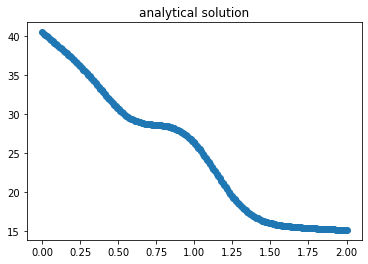

In [8]:
val_exact = np.zeros(len(X))
for idx, x in enumerate(X):
    cond_dist = reg.predict_target_distribution([x])
    val_exact[idx] = -1/10*cond_dist.moment(3) + cond_dist.moment(2) + 8*cond_dist.moment(1) + 16

_, ax = plt.subplots()
ax.scatter(X, val_exact)
ax.set_title('analytical solution')

Some integration methods from `conditional_expect` rely on certain assumptions, which determine how well
the integration method works. For this it is useful to see how the utility function
behaves in the regions where the conditional probability is high.

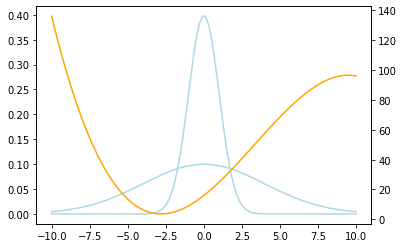

In [9]:
_, ax = plt.subplots()
y_space = np.linspace(-10, 10, 100)
ax.plot(y_space, norm.pdf(y_space, scale=4), c='lightblue')
ax.plot(y_space, norm.pdf(y_space, scale=1), c='lightblue')
ax_t = ax.twinx()
ax_t.plot(y_space, f(y_space), c='orange')

For example the method `assume_linear` only works well if the function is approximately linear
to a high probability. To get a feeling for how well different methods work under which
assumptions and how efficient they are, we specify different methods as parameters.

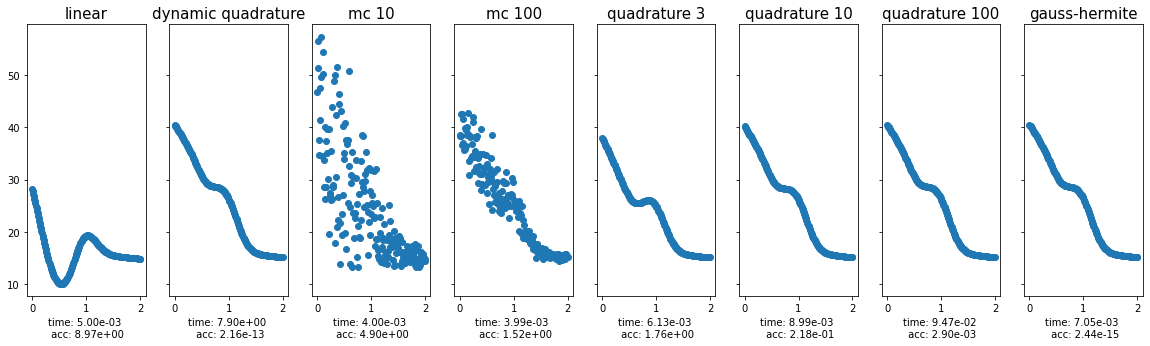

In [10]:
parameters = [
    ("linear", {"method":"assume_linear"}),
    ("dynamic quadrature", {"method":"dynamic_quad"}),
    ("mc 10", {"method":"monte_carlo", "n_integration_samples":10}),
    ("mc 100", {"method":"monte_carlo", "n_integration_samples":100}),
    ("quadrature 3", {"method":"quantile", "quantile_method":"quadrature", "n_integration_samples":3}),
    ("quadrature 10", {"method":"quantile", "quantile_method":"quadrature", "n_integration_samples":10}),
    ("quadrature 100", {"method":"quantile", "quantile_method":"quadrature", "n_integration_samples":100}),
    ("gauss-hermite", {"method":"gauss_hermite", "n_integration_samples":2})
]

_, axes = plt.subplots(1, len(parameters), figsize=(20, 5), sharey='all')
for (title, parameter), ax in zip(parameters, axes):
    t0 = time.time()
    val = conditional_expect(X, f, reg, **parameter, vector_func='both', random_state=random_state)
    t1 = time.time()
    dt = t1 - t0
    acc = np.average(np.abs(val_exact-val))
    ax.scatter(X, val)
    ax.set_title(title, fontdict={'fontsize': 15})
    ex_rep_acc = '{:.2e}'.format(acc)
    ex_rep_dt = '{:.2e}'.format(dt)
    ax.set_xlabel(f'time: {ex_rep_dt} \n acc: {ex_rep_acc}')

plt.show()

The plot to left with caption `linear` calculates the expected utility at a point
in the feature space by simply calculating $f(\mathbb{E}[x])$. It can be seen that this works well
on the right side of the feature space. There the standard deviation is much smaller
and thus the function is much more linear to a higher probability.

The second plot from the left with caption `adaptive quadrature` uses the method `expect`
from `scipy`. This method uses an adaptive version of Gaussian quadrature
to calculate the integral from $-\infty$ to $\infty$ of $f(y) \cdot \text{reg.predict_target_distribution($x$).pdf($y$)}$. This
method is exact but takes long. Further specifications can be
passed via `quad_dict`.

The third and forth plot from the left with caption `mc 10` and `mc 100` use
basic monte carlo integration with 10 and 100 samples.

The fifth, sixth and seventh plot from the left with caption `quadrature 3`, `quadrature 10`
and `quadrature 100` calculate the integral from $0$ to $1$ of $f(\text{reg.predict_target_distribution($x$).ppf($p$)})$ using gaussian
quadrature with 3, 10 or 100 points. Here $\text{ppf($p$)}$ means the percent point function
of $\text{reg.predict_target_distribution($x$)}$.

The eight plot with caption `gauss-hermite` uses Gauss-Hermite quadrature, with 2 points. This
method is exact for integrating polynomials of a degree smaller than or equal to
$2*n-1$ using $n$ points over a gaussian distribution. This is the
default method for `conditional_expect`.
